

> Importing the Libraries for the project.



In [ ]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

Found 2527 files belonging to 6 classes.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Counting images per class...

Image counts per class:
cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


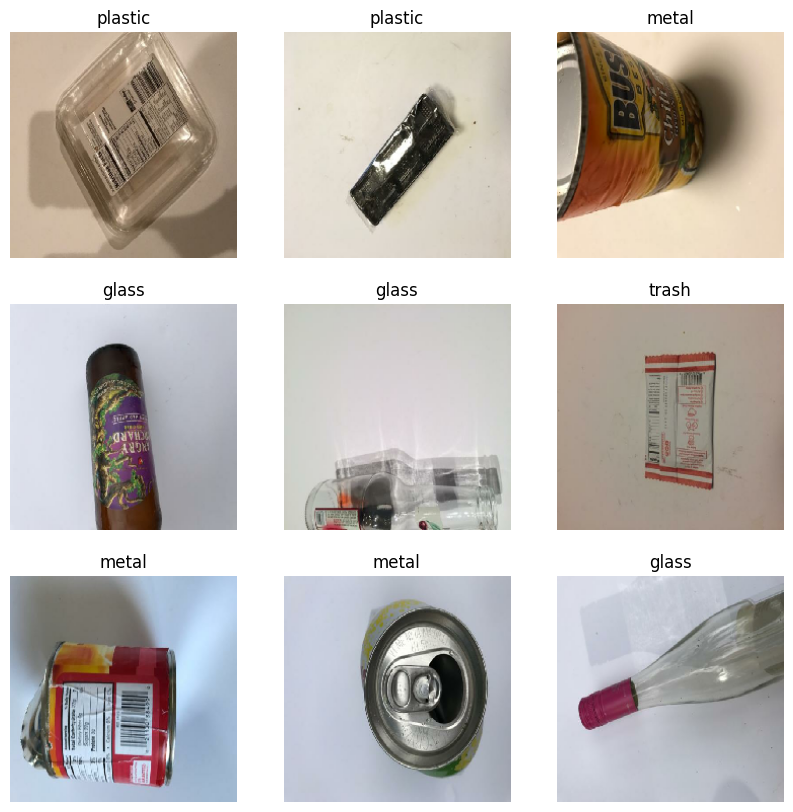

In [ ]:

# Replace 'path/to/your/dataset' with the actual path to your dataset.
dataset_dir = '/content/drive/MyDrive/TrashType_Image_Dataset' # Replace with your dataset path


image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

image_counts = {name: 0 for name in class_names}


print("Counting images per class...")
for images, labels in train_ds:
    for label in labels.numpy():

        class_index = np.argmax(label)
        class_name = class_names[class_index]
        image_counts[class_name] += 1

print("\nImage counts per class:")
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the class name from the one-hot encoded label
        class_index = np.argmax(labels[i].numpy())
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

# Task
Continue the project to train an image classification model on the "flower_photos" dataset, evaluate its performance, export the trained model, and build and launch a Gradio interface for user interaction.

## Split the dataset

### Subtask:
Split the dataset into training, validation, and testing sets.


**Reasoning**:
Split the dataset into training, validation, and test sets as instructed.



In [ ]:
# Define the split ratios
val_split = 0.2
test_split = 0.5 # of the remaining data after validation split

# Calculate the number of validation and test batches
val_batches = tf.data.experimental.cardinality(train_ds).numpy() * val_split
test_batches = tf.data.experimental.cardinality(train_ds).numpy() * (1 - val_split) * test_split
test_batches = int(test_batches)
val_batches = int(val_batches)

# Split the dataset
val_ds = train_ds.take(val_batches)
test_ds = train_ds.skip(val_batches).take(test_batches)
train_ds = train_ds.skip(val_batches).skip(test_batches)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Number of training batches: 33
Number of validation batches: 15
Number of test batches: 31


## Configure dataset for performance

### Subtask:
Apply data augmentation to the training dataset and prefetch data for better performance.

In [ ]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build the model

### Subtask:
Build a deep learning model for image classification.

In [ ]:
def build_model(num_classes):
    inputs = keras.Input(shape=image_size + (3,))

    # Use a pre-trained EfficientNetV2B2 model as the base
    base_model = EfficientNetV2B2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the base model's layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Add a dense output layer for classification
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create the model
    model = keras.Model(inputs, outputs)

    return model

# Build the model with the number of classes from the dataset
num_classes = len(class_names)
model = build_model(num_classes)

# Display the model summary
model.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

## Train the model

### Subtask:
Compile and train the model using the prepared datasets.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10  # You can adjust the number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.4293 - loss: 1.5222 - val_accuracy: 0.7521 - val_loss: 0.8196
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.7937 - loss: 0.7177 - val_accuracy: 0.8042 - val_loss: 0.6231
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.8505 - loss: 0.5373 - val_accuracy: 0.8208 - val_loss: 0.5391
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8337 - loss: 0.4710 - val_accuracy: 0.8229 - val_loss: 0.5012
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.8729 - loss: 0.4210 - val_accuracy: 0.8375 - val_loss: 0.4767
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.8705 - loss: 0.3818 - val_accuracy: 0.8333 - val_loss: 0.4548
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.9037 - loss: 0.3359 - val_accuracy: 0.8500 - val_loss: 0.4490
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.9145 - loss: 0.3114 - val_accuracy: 0.8375 - v

## Evaluate the model

### Subtask:
Evaluate the performance of the trained model using the test set.

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Optional: Generate a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predicted labels
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.8435 - loss: 0.4069
Test Loss: 0.3546420931816101
Test Accuracy: 0.8699596524238586
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

## Export the model

### Subtask:
Save the trained model for future use.

In [ ]:
model.save("trash_type_model.keras")

## Build a Gradio interface

### Subtask:
Create a Gradio interface to interact with the trained model.

In [ ]:
def classify_image(image):
    """
    Classifies the input image using the trained model.

    Args:
        image: A NumPy array representing the input image.

    Returns:
        A dictionary containing the class probabilities.
    """
    # Resize the image to the expected input size
    img = tf.image.resize(image, image_size)
    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)
    # Make a prediction
    predictions = model.predict(img)
    # Get the class probabilities
    probabilities = predictions[0]
    # Create a dictionary of class names and probabilities
    results = {class_names[i]: float(probabilities[i]) for i in range(len(class_names))}
    return results

# Create the Gradio interface
image_input = gr.Image()
label_output = gr.Label()

interface = gr.Interface(
    fn=classify_image,
    inputs=image_input,
    outputs=label_output,
    title="Trash Type Classifier",
    description="Upload an image of trash to classify its type."
)

## Launch the Gradio interface

### Subtask:
Launch the Gradio interface to allow users to test the model.

In [ ]:
interface.launch(debug=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://356712c33c5c9ad115.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


KeyboardInterrupt: 

# Task
Compare the provided notebook "/content/Garbage Classification using Transfer learning code.ipynb" with a project that implements garbage classification using transfer learning, highlighting the differences and the changes made to align with the requested steps: Step 1: Installing Necessary Libraries, Step 2: Importing Libraries, Step 3: Loading Data, Step 4: Visualizing the Dataset, Step 5: Enhanced Class Distribution Visualization, Step 6: Calculating Class Weights to Handle Imbalance, Step 7: Preprocessing and Model Training, Step 8: Model Evaluation, Step 9: Final Testing, and Step 10: Retraining Model. Explain if the project is similar to the uploaded file and if it is better, ensuring all the specified steps are properly included.

## Add class weight calculation

### Subtask:
Add a code cell to calculate class weights based on the training dataset.


**Reasoning**:
Calculate class weights from the training dataset labels to address potential class imbalance.



In [ ]:
# Extract labels from the training dataset
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_labels_indices = np.argmax(train_labels, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_indices),
    y=train_labels_indices
)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:")
print(class_weight_dict)

Class Weights:
{0: np.float64(1.0047619047619047), 1: np.float64(0.8747927031509121), 2: np.float64(1.0222868217054264), 3: np.float64(0.717687074829932), 4: np.float64(0.8577235772357723), 5: np.float64(3.084795321637427)}


## Modify training cell

### Subtask:
Modify the training cell to include the calculated class weights and add Early Stopping and Model Checkpoint callbacks.


**Reasoning**:
Import the necessary callbacks and modify the training call to include class weights and callbacks as instructed.



In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True # Restore the best weights from the epoch with the lowest validation loss
)

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_trash_type_model.keras', # File path to save the model
    monitor='val_loss',          # Monitor the validation loss
    save_best_only=True,         # Save only the best model
    save_weights_only=False      # Save the entire model (architecture and weights)
)


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with class weights and callbacks
epochs = 10  # Increase epochs as Early Stopping will prevent overfitting
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight_dict,  # Include class weights
    callbacks=[early_stopping, model_checkpoint] # Include callbacks
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.9753 - loss: 0.1221 - val_accuracy: 0.8479 - val_loss: 0.4073
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.9717 - loss: 0.1255 - val_accuracy: 0.8646 - val_loss: 0.3846
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9789 - loss: 0.1019 - val_accuracy: 0.8583 - val_loss: 0.3939
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.9859 - loss: 0.0919 - val_accuracy: 0.8646 - val_loss: 0.3837
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.9804 - loss: 0.0979 - val_accuracy: 0.8604 - val_loss: 0.3847
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.9769 - loss: 0.1095 - val_accuracy: 0.8562 - val_loss: 0.3883
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9813 - loss: 0.0887 - val_accuracy: 0.8604 - val_loss: 0.3939
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9867 - loss: 0.0936 - val_accuracy: 0.8500 - v

## Enhanced Class Distribution Visualization

### Subtask:
Visualize the class distribution using a bar plot.

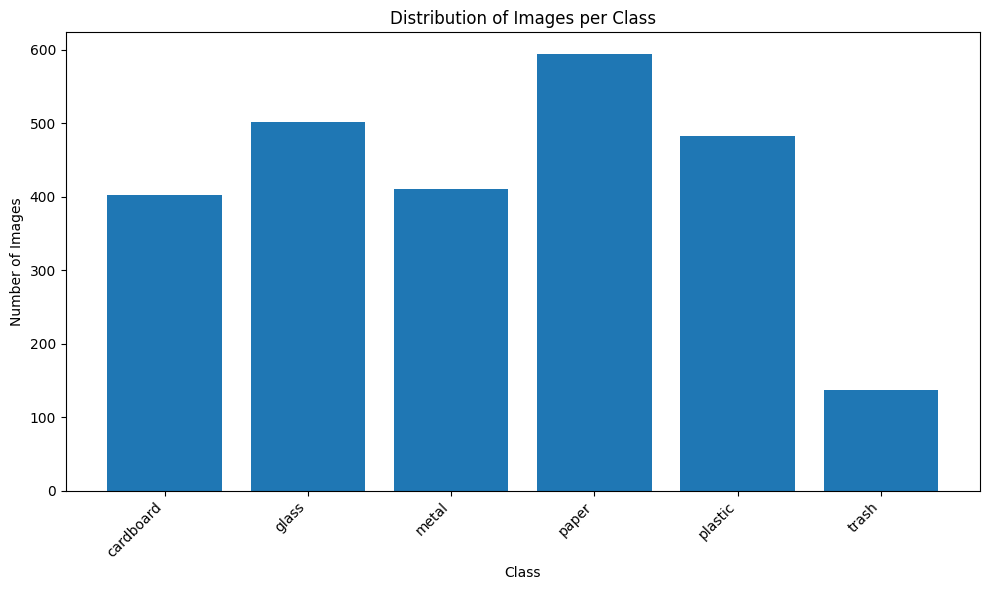

In [22]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values())
plt.title("Distribution of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()